# Extract Features

In [3]:
import cv2  # Computer vision library for image I/O and processing
import os   # Operating system utilities (paths, directory listing)
import numpy as np  # Numerical arrays and math operations
import torch  # PyTorch core
from torchvision import transforms  # Image transforms (resize, tensor conversion, normalization)
import torchvision.models as models  # Pretrained models (ResNet18)
import torch.nn as nn  # Neural network building blocks

# Load a pretrained ResNet18 with ImageNet weights
resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)  # Full model including classifier head
# Remove the final fully connected layer to use ResNet as a feature extractor
resnet_no_output = nn.Sequential(*list(resnet.children())[:-1])  # Outputs feature maps (512, 1, 1)


def extract_features(data_dir, model):  # Extract 512-d features and labels from a folder structure
    model.eval()  # Set model to evaluation mode (disable dropout/batchnorm updates)

    features = []  # Accumulates 512-d feature vectors
    labels = []    # Accumulates integer class indices

    # List class directories (one folder per class) and sort them for stable indexing
    classes_names = [entry.name for entry in os.scandir(data_dir) if entry.is_dir()]  # Class names from folders
    classes_names = sorted(classes_names)  # Ensure consistent class->index mapping

    # Define image preprocessing: PIL conversion, resize, tensor, normalize (ImageNet stats)
    preprocess = transforms.Compose([
        transforms.ToPILImage(),                   # Convert NumPy array (H,W,C) to PIL Image
        transforms.Resize((224, 224)),             # Resize to 224x224 expected by ResNet18
        transforms.ToTensor(),                     # Convert to torch.FloatTensor (C,H,W) scaled to [0,1]
        transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean
                             std=[0.229, 0.224, 0.225])   # ImageNet std
    ])  # Preprocessing pipeline

    # Loop over classes with their numeric indices
    for class_index, class_name in enumerate(classes_names):  # Enumerate class folders deterministically
        class_path = os.path.join(data_dir, class_name)       # Absolute path to current class folder
        print(f"Loading Class {class_index}: {class_name}")   # Progress logging

        # Iterate images inside the class folder
        for img_name in os.listdir(class_path):               # All files in class folder
            img_path = os.path.join(class_path, img_name)     # Build full path

            try:
                img_np_arr = cv2.imread(img_path)             # Read image via OpenCV (BGR channel order)

                if img_np_arr is None:                        # Skip unreadable files
                    continue

                img_rgb = cv2.cvtColor(img_np_arr, cv2.COLOR_BGR2RGB)  # Convert BGR->RGB for consistency
                img_t = preprocess(img_rgb)                   # Apply preprocessing pipeline
                input_batch = img_t.unsqueeze(0)              # Add batch dimension (1, C, H, W)

                # Extract features without computing gradients
                with torch.no_grad():
                    output_tensor = model(input_batch)        # Forward pass through feature extractor
                    feature_vector = output_tensor.flatten().cpu().numpy()  # Flatten (1,512,1,1)->(512,) on CPU

                features.append(feature_vector)               # Store feature vector
                labels.append(class_index)                    # Store class index

            except Exception as e:                            # Robustness against corrupt images
                print(f"Error loading {img_name}: {e}")

    return np.array(features), np.array(labels), classes_names  # Numpy arrays and ordered class names


# Splitting the data

In [4]:
from sklearn.model_selection import train_test_split  # Stratified train/val/test splits
# features, labels, classes_names = extract_features(r"D:\College\Year 3\TFML\Assignments\Assignment_2\Sea_Animals",resnet_no_output)  # Example alt path
# Extract features from dataset root using the ResNet18 feature extractor
features, labels, classes_names = extract_features(r"C:\Life\FCAI_Stuff\Third_year_AI\Intro_to_ML\Assignments\Sea_Animals", resnet_no_output)

# First split: training+validation vs test (stratified to preserve class proportions)
x_train_validate, x_test, y_train_validate, y_test = train_test_split(
    features,                 # Full feature array (N, 512)
    labels,                   # Integer labels (N,)
    test_size=0.15,           # 15% for final test set
    stratify=labels,          # Preserve class distribution
    random_state=42           # Reproducibility
) 
# Second split: training vs validation from the remaining pool (also stratified)
x_train, x_val, y_train, y_val = train_test_split(
    x_train_validate,         # Features for train+val
    y_train_validate,         # Labels for train+val
    test_size=0.15,           # 15% of train+val becomes validation
    stratify=y_train_validate,# Preserve distribution again
    random_state=42           # Reproducibility
)

Loading Class 0: Clams
Loading Class 1: Corals
Loading Class 2: Crabs
Loading Class 3: Dolphin
Loading Class 4: Eel
Loading Class 5: Fish
Loading Class 6: Jelly_Fish
Loading Class 7: Lobster
Loading Class 8: Nudibranchs
Loading Class 9: Octopus
Loading Class 10: Otter
Loading Class 11: Penguin
Loading Class 12: Puffers
Loading Class 13: Sea_Rays
Loading Class 14: Sea_Urchins
Loading Class 15: Seahorse
Loading Class 16: Seal
Loading Class 17: Sharks
Loading Class 18: Shrimp
Loading Class 19: Squid
Loading Class 20: Starfish
Loading Class 21: Turtle_Tortoise
Loading Class 22: Whale


# Marine Model definition

In [5]:
class MarineModel(nn.Module):  # Flexible MLP classifier with variable hidden layers and activation
    def __init__(self, input_size, layers_sizes, output_size, func):
        super(MarineModel, self).__init__()  # Initialize nn.Module

        layers = []                 # Sequential container fragments
        current_dim = input_size    # Track input dimension to each layer
        activ_funcs = {             # Supported activations
            'relu': nn.ReLU(),
            'sigmoid': nn.Sigmoid(),
            'tanh': nn.Tanh()
        }

        for hidden_dim in layers_sizes:                 # Build hidden layers one by one
            layers.append(nn.Linear(current_dim, hidden_dim))  # Linear layer from current_dim -> hidden_dim
            layers.append(activ_funcs[func])                   # Nonlinearity after linear layer
            current_dim = hidden_dim                           # Update for next layer
        # Add the final output layer mapping to class logits
        layers.append(nn.Linear(current_dim, output_size))     # No activation here (CrossEntropyLoss expects logits)
        # Pack all layers into a Sequential model
        self.network = nn.Sequential(*layers)                  # Create the forward chain
        
    def forward(self, x):                 # Define forward pass
        return self.network(x)            # Feed inputs through the chain

loss_function = nn.CrossEntropyLoss()     # Multi-class classification loss (applies LogSoftmax+NLL internally)

# Fitness Function (Train and Evaluate)

In [6]:
from torch.utils.data import TensorDataset, DataLoader  # Data wrappers and loaders for batches
import torch.optim as optim  # Optimizers (SGD, Adam, etc.)


def train_and_evalute(hyperparms, x_train, y_train, x_val, y_val, input_size, num_classes, device):
    """
    Acts as the fitness function for random search.
    Input: Dictionary of hyperparameters.
    Output: Best Validation Accuracy (%) achieved during training.
    """

    # 1) Unpack Hyperparameters
    hidden_layers = hyperparms['hidden_layers']   # List of hidden layer sizes
    activation = hyperparms['activation']         # Activation name ('relu'/'tanh'/'sigmoid')
    batch_size = hyperparms['batch_size']         # Mini-batch size
    learning_rate = hyperparms['learning_rate']   # Learning rate
    optimizer_name = hyperparms['optimizer']      # Optimizer type
    epochs = hyperparms['epochs']                 # Number of epochs to train

    # 2) Prepare DataLoaders
    train_ds = TensorDataset(torch.tensor(x_train).float(), torch.tensor(y_train).long())  # Train dataset
    val_ds = TensorDataset(torch.tensor(x_val).float(), torch.tensor(y_val).long())        # Validation dataset
    
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)   # Shuffle for training
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)      # No shuffle for eval

    # 3) Initialize Model
    model = MarineModel(input_size, hidden_layers, num_classes, activation).to(device)  # Instantiate MLP
    optim_type = {                                                    # Optimizer factory
        'SGD': optim.SGD(model.parameters(), lr=learning_rate),
        'Adam': optim.Adam(model.parameters(), lr=learning_rate),
        'RMSProp': optim.RMSprop(model.parameters(), lr=learning_rate),
        'Adagrad': optim.Adagrad(model.parameters(), lr=learning_rate)
    }
    optimizer = optim_type[optimizer_name]                            # Select optimizer

    loss_fn = nn.CrossEntropyLoss()                                   # Classification loss

    # 4) Training & Validation loop
    best_val_acc = 0.0                                               # Track best validation accuracy

    for epoch in range(epochs):                                       # Iterate epochs
        model.train()                                                 # Training mode
        for inputs, labels in train_loader:                           # Over train batches
            inputs, labels = inputs.to(device), labels.to(device)     # Move to device
            optimizer.zero_grad()                                     # Reset gradients
            outputs = model(inputs)                                   # Forward pass
            loss = loss_fn(outputs, labels)                           # Compute loss
            loss.backward()                                           # Backpropagate
            optimizer.step()                                          # Update weights
            
        model.eval()                                                  # Validation mode
        correct = 0                                                   # Correct predictions
        total = 0                                                     # Total samples

        with torch.no_grad():                                         # No gradients needed for eval
            for inputs, labels in val_loader:                         # Iterate val batches
                inputs, labels = inputs.to(device), labels.to(device) # Move to device
                outputs = model(inputs)                               # Forward pass
                _, predicted = torch.max(outputs, 1)                  # Predicted class
                total += labels.size(0)                               # Update total
                correct += (predicted == labels).sum().item()         # Update correct

        val_acc = 100 * correct / total                               # Compute validation accuracy (%)
        if val_acc > best_val_acc:                                    # Track best
            best_val_acc = val_acc

    return best_val_acc                                               # Fitness score for hyperparams

# Optimizing function

In [7]:
import random  # Random sampling utilities


def random_search(n_iterations, x_train, y_train, x_val, y_val, input_size, num_classes, device):
    """Randomly sample hyperparameters and return the best found by validation accuracy."""

    best_score = 0                 # Track best validation accuracy (%)
    best_params = {}               # Track corresponding hyperparameters
    results_log = []               # Keep a log of (hyperparams, val_acc)

    print(f"Starting Random Search for {n_iterations} iterations...")  # Progress

    for i in range(n_iterations):
        # --- 1. Randomly Sample Hyperparameters ---
        num_layers = random.randint(1, 5)                                   # Hidden layer count [1..5]
        hidden_layers = [random.randint(32, 512) for _ in range(num_layers)] # Each layer size ∈ [32,512]
        activation = random.choice(['relu', 'tanh', 'sigmoid'])              # Activation choice

        # Training hyperparameters
        lr_exponent = random.uniform(-5, -1)       # Sample exponent in [-5, -1]
        learning_rate = 10 ** lr_exponent          # LR in [1e-5, 1e-1]
        batch_size = random.choice([16, 32, 64, 128])  # Batch size options
        optimizer = random.choice(['SGD', 'Adam', 'RMSProp', 'Adagrad'])     # Optimizer choice
        epochs = random.randint(3, 20)             # Epochs in [3..20]

        hyperparms = {                             # Bundle into a dict for fitness function
            'hidden_layers': hidden_layers,
            'activation': activation,
            'learning_rate': learning_rate,
            'batch_size': batch_size,
            'optimizer': optimizer,
            'epochs': epochs
        }

        # --- 2. Evaluate Fitness ---
        print(f"\nIteration {i + 1}/{n_iterations}: Testing {hyperparms}")  # Iteration header

        try:
            val_acc = train_and_evalute(             # Train and get best val acc (%) for this config
                hyperparms, x_train, y_train, x_val, y_val,
                input_size, num_classes, device
            )
            print(f"Result: Validation Acc = {val_acc: .2f}%")        # Report validation performance

            # --- 3. Track Best Solution ---
            results_log.append((hyperparms, val_acc))                 # Log result

            if val_acc > best_score:                                  # Update best if improved
                best_score = val_acc
                best_params = hyperparms
                print(">>> New Best Model Found! <<<")               # Highlight improvement

        except Exception as e:                                         # Catch and log failures
            print(f"Iteration failed: {e}")

    print("\n--- Random Search Complete ---")                  # End-of-search banner
    print(f"Best Accuracy: {best_score:.2f}%")           # Print best val accuracy
    print(f"Best Params: {best_params}")                 # Print best configuration
    
    return best_params, best_score, results_log            # Return best and history

In [8]:
input_size = 512
num_classes = 23
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_params, best_acc, history = random_search(
    n_iterations = 5, # Start small to test
    x_train = x_train, 
    y_train = y_train, 
    x_val = x_val, 
    y_val = y_val,
    input_size = input_size, 
    num_classes = num_classes, 
    device = device
)

Starting Random Search for 5 iterations...

Iteration 1/5: Testing {'hidden_layers': [48, 79], 'activation': 'relu', 'learning_rate': 0.00022481310409223218, 'batch_size': 32, 'optimizer': 'Adagrad', 'epochs': 4}
Result: Validation Acc =  21.90%
>>> New Best Model Found! <<<

Iteration 2/5: Testing {'hidden_layers': [215, 268, 167], 'activation': 'relu', 'learning_rate': 0.0018181245441079305, 'batch_size': 16, 'optimizer': 'Adagrad', 'epochs': 17}
Result: Validation Acc =  75.59%
>>> New Best Model Found! <<<

Iteration 3/5: Testing {'hidden_layers': [480, 460, 240, 100, 110], 'activation': 'sigmoid', 'learning_rate': 2.556670139064964e-05, 'batch_size': 32, 'optimizer': 'RMSProp', 'epochs': 15}
Result: Validation Acc =  22.53%

Iteration 4/5: Testing {'hidden_layers': [436, 372, 392, 374], 'activation': 'tanh', 'learning_rate': 4.114074596244534e-05, 'batch_size': 64, 'optimizer': 'Adam', 'epochs': 20}
Result: Validation Acc =  76.84%
>>> New Best Model Found! <<<

Iteration 5/5: Tes

# Genetic Algorithm (GA) 🧬

In [26]:
# Genetic search space: each key (gene) encodes one hyperparameter to explore
GENE_SPACE = {
    'hidden_layers': [1, 2, 3, 4, 5],                 # Number of hidden layers in the MLP
    'neurons': [32, 64, 128, 256, 512],               # Neurons per hidden layer (uniform across layers here)
    'activation': ['relu', 'tanh', 'sigmoid'],        # Activation function used in hidden layers
    'learning_rate': [-5, -1],                        # Exponent range for 10^x so LR ∈ [1e-5, 1e-1]
    'batch_size': [16, 32, 64, 128],                  # Batch size for DataLoaders
    'optimizer': ['SGD', 'Adam', 'RMSProp', 'Adagrad'],# Optimizer choices
    'epochs': list(range(3, 21))                      # Epoch count from 3 to 20 inclusive
}


def get_random_chromosome():
    """
    Sample a random chromosome from the gene space.
    A chromosome is a dict that fully specifies one model/training configuration.
    """
    # Draw each hyperparameter at random (some on a log scale for LR)
    return {
        'hidden_layers': random.randint(1, 5),                          # Random hidden layer count
        'neurons': random.randint(32, 512),                              # Random neuron count per hidden layer
        'activation': random.choice(['relu', 'tanh', 'sigmoid']),        # Random activation
        # Use a log-uniform distribution for learning rate
        'learning_rate': 10 ** random.uniform(-5, -1),                   # LR in [1e-5, 1e-1]
        'batch_size': random.choice([16, 32, 64, 128]),                  # Random batch size
        'optimizer': random.choice(['SGD', 'Adam', 'RMSProp', 'Adagrad']),# Random optimizer type
        'epochs': random.randint(3, 20)                                  # Random epoch count
    }


def init_population(n_individuals):
    """
    Create the initial population of chromosomes by random sampling.
    """
    population = []                                                      # Accumulator for chromosomes
    for _ in range(n_individuals):                                       # Repeat for population size
        chromosome = get_random_chromosome()                             # Sample one configuration
        population.append(chromosome)                                    # Add to population
    return population                                                    # Return list of chromosomes


def select_parents(population, fitness_scores, k=3):
    """
    Tournament selection:
    - Randomly pick k individuals by index
    - Return the one with the highest fitness (accuracy)
    """
    selection_ix = random.sample(range(len(population)), k)              # Random k indexes
    best_ix = selection_ix[0]                                            # Initialize with first candidate
    for ix in selection_ix:                                              # Compare k candidates
        if fitness_scores[ix] > fitness_scores[best_ix]:                 # Keep the fittest
            best_ix = ix
    return population[best_ix]                                           # Return selected parent

# Crossover and mutate

In [27]:
def crossover(parent_a, parent_b):
    """
    Uniform crossover: for each gene (key), pick the value from either parent
    with 50% probability to create a new child chromosome.
    """
    child = {}                                                          # New chromosome to build
    for key in parent_a.keys():                                         # Iterate all genes
        if random.random() < 0.5:                                       # 50/50 coin flip
            child[key] = parent_a[key]                                  # Inherit from parent A
        else:
            child[key] = parent_b[key]                                  # Inherit from parent B
    return child


def mutate(child, mutation_rate):
    """
    Random mutation: with probability = mutation_rate, resample the value of each gene
    from the gene space by calling get_random_chromosome() and copying that gene.
    """
    for key in child.keys():                                            # Consider every gene
        if random.random() < mutation_rate:                             # Apply mutation with given rate
            random_genes = get_random_chromosome()                      # Fresh random chromosome
            child[key] = random_genes[key]                              # Replace this gene's value
    return child                                                        # Return possibly mutated child

# Train and Evaluate on each chromosome

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


def train_and_evaluate_model(chromosome):
    """
    Build, train, and validate an MLP defined by a GA chromosome.
    Returns validation accuracy as a percentage (fitness).
    """
    # 1) Unpack hyperparameters from chromosome
    lr = chromosome['learning_rate']                                   # Learning rate
    batch_size = chromosome['batch_size']                               # DataLoader batch size
    optimizer_name = chromosome['optimizer']                            # Optimizer type
    epochs = chromosome['epochs']                                       # Training epochs

    # Translate GA encoding into MarineModel hidden layer sizes
    layers_sizes = [chromosome['neurons']] * chromosome['hidden_layers']# e.g., [128, 128, 128] if 3 layers x 128 neurons

    # 2) Create TensorDatasets for train and validation splits
    train_ds = TensorDataset(torch.tensor(x_train).float(), torch.tensor(y_train).long())
    val_ds = TensorDataset(torch.tensor(x_val).float(), torch.tensor(y_val).long())

    # 3) DataLoaders with chosen batch size
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size)

    # 4) Initialize model according to chromosome
    model = MarineModel(
        input_size=x_train.shape[1],                                    # Feature dimension (512)
        layers_sizes=layers_sizes,                                      # Hidden architecture
        output_size=num_classes,                                        # Number of classes
        func=chromosome['activation']                                   # Activation function
    ).to(device)

    # 5) Optimizer selection
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == 'RMSProp':
        optimizer = optim.RMSprop(model.parameters(), lr=lr)
    elif optimizer_name == 'Adagrad':
        optimizer = optim.Adagrad(model.parameters(), lr=lr)

    criterion = nn.CrossEntropyLoss()                                   # Multi-class classification loss

    # 6) Train for the specified number of epochs
    for _ in range(epochs):
        model.train()                                                   # Enable training behaviors
        for X_batch, y_batch in train_loader:                           # Iterate batches
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)   # Move to device
            optimizer.zero_grad()                                       # Reset gradients
            outputs = model(X_batch)                                    # Forward pass
            loss = criterion(outputs, y_batch)                          # Compute loss
            loss.backward()                                             # Backpropagate
            optimizer.step()                                            # Update parameters

    # 7) Evaluate on validation set and compute accuracy (%)
    model.eval()                                                        # Evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():                                               # No grad tracking for eval
        for X_batch, y_batch in val_loader:                             # Iterate val batches
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)   # Move to device
            outputs = model(X_batch)                                    # Forward
            _, predicted = torch.max(outputs.data, 1)                   # Argmax for class index
            total += y_batch.size(0)                                    # Count samples
            correct += (predicted == y_batch).sum().item()              # Count correct predictions

    accuracy = 100.0 * correct / total                                  # Accuracy as percentage
    return accuracy                                                     # Fitness for GA

# Genetic Algorithm Search

In [29]:
def genetic_algorithm_search(n_generations, population_size, mutation_rate):
    """
    Run a Genetic Algorithm over the defined chromosome space.
    - Initializes a random population
    - Repeats for n_generations: evaluate, select, crossover, mutate
    - Uses elitism (keeps best individual of the current generation)
    Returns the best chromosome found across all generations.
    """
    # 1) Initialize population
    population = init_population(population_size)                       # Random initial pool
    best_overall_score = 0.0                                            # Track best accuracy found
    best_overall_chromosome = None                                      # Track best chromosome

    for generation in range(n_generations):                              # Loop over generations
        print(f"--- Generation {generation + 1} ---")
        fitness_scores = []                                             # Store fitness per individual

        # 2) Evaluate fitness for each chromosome in population
        for chromosome in population:                                   # Loop through individuals
            accuracy = train_and_evaluate_model(chromosome)             # Fitness = validation accuracy (%)
            fitness_scores.append(accuracy)                             # Record fitness

            # Track the best solution seen so far (global best)
            if accuracy > best_overall_score:
                best_overall_score = accuracy
                best_overall_chromosome = chromosome

        print(f"Best score in Gen {generation+1}: {max(fitness_scores):.2f}%")

        # 3) Create next generation
        new_population = []                                             # Offspring (next gen)

        # Elitism: keep the best individual of this generation
        best_gen_idx = fitness_scores.index(max(fitness_scores))        # Index of best in current generation
        new_population.append(population[best_gen_idx])                 # Copy elite to next generation

        # Fill the rest of the population via selection, crossover, and mutation
        while len(new_population) < population_size:
            parent_a = select_parents(population, fitness_scores)       # Tournament selection for parent A
            parent_b = select_parents(population, fitness_scores)       # Tournament selection for parent B

            child = crossover(parent_a, parent_b)                       # Combine genes from parents
            child = mutate(child, mutation_rate)                        # Randomly mutate some genes
            new_population.append(child)                                # Add child to next generation

        population = new_population                                     # Advance to next generation

    print(f"\nOptimization Complete. Best Accuracy: {best_overall_score:.2f}%")
    print(f"Best Hyperparameters: {best_overall_chromosome}")
    return best_overall_chromosome                                     # Return the best configuration

# GA Run

In [21]:
# Run GA with a moderate search budget (adjust as needed)
# - n_generations: number of evolution cycles
# - population_size: individuals per generation
# - mutation_rate: chance to resample each gene when mutating a child

ga_best = genetic_algorithm_search(
    n_generations=5,
    population_size=8,
    mutation_rate=0.2,
)
print("Best from GA run:", ga_best)  # Displays best chromosome (hyperparameters)

--- Generation 1 ---
Best score in Gen 1: 75.99%
--- Generation 2 ---
Best score in Gen 2: 77.70%
--- Generation 3 ---
Best score in Gen 3: 78.10%
--- Generation 4 ---
Best score in Gen 4: 77.53%
--- Generation 5 ---
Best score in Gen 5: 77.59%

Optimization Complete. Best Accuracy: 78.10%
Best Hyperparameters: {'hidden_layers': 4, 'neurons': 435, 'activation': 'tanh', 'learning_rate': 9.379880878313753e-05, 'batch_size': 64, 'optimizer': 'RMSProp', 'epochs': 14}
Best from GA run: {'hidden_layers': 4, 'neurons': 435, 'activation': 'tanh', 'learning_rate': 9.379880878313753e-05, 'batch_size': 64, 'optimizer': 'RMSProp', 'epochs': 14}


# Predict Function

In [ ]:
def predict_pytorch_model(model, test_feature, classes_names):
    """
    Predict the class name for a single feature vector using a trained PyTorch model.

    Inputs:
    - model: Trained classifier (e.g., MarineModel instance).
    - test_feature: One sample feature as a NumPy array (shape: (512,)) or a 1D/2D torch.Tensor.
    - classes_names: List of class names indexed by label id.

    Prints and returns the predicted class name as a string.
    """
    model.eval()                                                        # Set model to evaluation mode

    # Ensure the input is a float tensor (convert from numpy if needed)
    if isinstance(test_feature, np.ndarray):                            # If provided as NumPy array
        test_feature = torch.from_numpy(test_feature).float()           # Convert to float tensor

    # Add batch dimension if input is a single 1D vector (512,) -> (1, 512)
    if len(test_feature.shape) == 1:                                    # If single sample 1D
        test_feature = test_feature.unsqueeze(0)                        # Add batch dimension

    test_feature = test_feature.to(device)                              # Move input to the correct device

    with torch.no_grad():                                               # Disable gradient computation for inference
        output = model(test_feature)                                    # Forward pass through the model
        _, predicted_idx = torch.max(output, 1)                         # Argmax over class logits -> predicted index
        predicted_class = classes_names[predicted_idx.item()]           # Map index to class name

    print(f"Predicted Class: {predicted_class}")                        # User-friendly output
    return predicted_class                                              # Return class name

# The Dymamic Training Function to compare between all differnt approaches

In [22]:
from torch.utils.data import TensorDataset, DataLoader  # Import PyTorch dataset and dataloader utilities


def build_loaders(batch_size):  # Create train/val/test DataLoaders with a given batch size
    train_ds = TensorDataset(torch.tensor(x_train).float(), torch.tensor(y_train).long())  # Wrap training arrays as tensors and pair (features, labels)
    val_ds = TensorDataset(torch.tensor(x_val).float(), torch.tensor(y_val).long())        # Wrap validation arrays as tensors and pair (features, labels)
    test_ds = TensorDataset(torch.tensor(x_test).float(), torch.tensor(y_test).long())     # Wrap test arrays as tensors and pair (features, labels)

    return (
        DataLoader(train_ds, batch_size=batch_size, shuffle=True),   # Shuffle train for SGD
        DataLoader(val_ds, batch_size=batch_size, shuffle=False),    # No shuffle for evaluation
        DataLoader(test_ds, batch_size=batch_size, shuffle=False),   # No shuffle for evaluation
    )


def evaluate_accuracy(model, loader, device):  # Compute accuracy (%) of a model over a dataloader
    model.eval()                               # Put model in eval mode (disable dropout/batchnorm updates)
    correct = 0                                 # Counter for correct predictions
    total = 0                                   # Counter for total samples
    with torch.no_grad():                       # Disable gradients for evaluation
        for inputs, labels in loader:           # Iterate over batches
            inputs, labels = inputs.to(device), labels.to(device)  # Move batch to device (CPU/GPU)
            outputs = model(inputs)                                # Forward pass
            _, predicted = torch.max(outputs.data, 1)              # Top-1 predicted class per sample
            total += labels.size(0)                                # Update total samples
            correct += (predicted == labels).sum().item()          # Update correct predictions
    return 100.0 * correct / total              # Return accuracy as percentage


def train_model(hparams, run_name="run"):  # Train a model using a hyperparameter dict and return model, history, and test acc
    batch_size = hparams['batch_size']       # Mini-batch size
    lr = hparams['learning_rate']            # Learning rate
    optimizer_name = hparams['optimizer']    # Optimizer choice
    epochs = hparams['epochs']               # Number of training epochs
    hidden_layers = hparams['hidden_layers'] # Hidden layer sizes list (e.g., [256, 128])
    activation = hparams['activation']       # Activation name for hidden layers

    train_loader, val_loader, test_loader = build_loaders(batch_size)  # Build dataloaders

    model = MarineModel(                      # Instantiate the MLP classifier
        input_size=x_train.shape[1],          # Input dimensionality (feature size)
        layers_sizes=hidden_layers,           # Hidden layers configuration
        output_size=num_classes,              # Number of output classes
        func=activation,                      # Activation function name
    ).to(device)                              # Move model to device

    optimizer_map = {                         # Map optimizer names to PyTorch optimizers
        'SGD': optim.SGD(model.parameters(), lr=lr),
        'Adam': optim.Adam(model.parameters(), lr=lr),
        'RMSProp': optim.RMSprop(model.parameters(), lr=lr),
        'Adagrad': optim.Adagrad(model.parameters(), lr=lr),
    }
    optimizer = optimizer_map[optimizer_name] # Select optimizer
    criterion = loss_function                  # Use predefined CrossEntropyLoss

    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}  # Track metrics per epoch

    print(f"Training {run_name} on {device} for {epochs} epochs...")  # Log run header
    for epoch in range(epochs):               # Training loop over epochs
        model.train()                         # Set model to train mode
        running_loss = 0.0                    # Accumulate training loss
        train_correct = 0                     # Accumulate correct train predictions
        train_total = 0                       # Accumulate train samples

        for inputs, labels in train_loader:   # Iterate over train batches
            inputs, labels = inputs.to(device), labels.to(device)  # Move to device
            optimizer.zero_grad()             # Zero gradients from previous step
            outputs = model(inputs)           # Forward pass
            loss = criterion(outputs, labels) # Compute loss
            loss.backward()                   # Backpropagate
            optimizer.step()                  # Update weights
            running_loss += loss.item()       # Accumulate batch loss
            _, predicted = torch.max(outputs.data, 1)  # Batch predictions
            train_total += labels.size(0)     # Update train samples
            train_correct += (predicted == labels).sum().item()  # Update correct count

        model.eval()                          # Switch to eval mode for validation
        val_loss = 0.0                        # Accumulate validation loss
        val_correct = 0                       # Accumulate correct val predictions
        val_total = 0                         # Accumulate val samples
        with torch.no_grad():                 # Disable gradients for validation
            for inputs, labels in val_loader: # Iterate val batches
                inputs, labels = inputs.to(device), labels.to(device)  # Move to device
                outputs = model(inputs)        # Forward pass
                loss = criterion(outputs, labels)  # Compute val loss
                val_loss += loss.item()        # Accumulate loss
                _, predicted = torch.max(outputs.data, 1)  # Predicted labels
                val_total += labels.size(0)    # Update samples
                val_correct += (predicted == labels).sum().item()  # Update correct

        avg_train_loss = running_loss / len(train_loader)   # Mean train loss
        avg_val_loss = val_loss / len(val_loader)           # Mean val loss
        train_acc = 100.0 * train_correct / train_total     # Train accuracy (%)
        val_acc = 100.0 * val_correct / val_total           # Val accuracy (%)

        history['train_loss'].append(avg_train_loss)        # Log epoch train loss
        history['val_loss'].append(avg_val_loss)            # Log epoch val loss
        history['train_acc'].append(train_acc)              # Log epoch train acc
        history['val_acc'].append(val_acc)                  # Log epoch val acc

        print(                                             # Print epoch metrics
            f"Epoch {epoch + 1}/{epochs} | "
            f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
            f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%"
        )

    test_acc = evaluate_accuracy(model, test_loader, device)  # Evaluate on held-out test set
    print(f"{run_name} finished. Test Acc: {test_acc:.2f}%\n")   # Log test accuracy
    return model, history, test_acc                             # Return model and metrics

# Final Training Runs

In [25]:
# Final training runs: baseline, random-search best, GA best


def normalize_params(params):  # Ensure hyperparams have list for hidden layers
    layers = params['hidden_layers']               # Extract hidden layers setting
    if isinstance(layers, int):                    # If single int, convert to list
        layers = [layers]
    return {
        'hidden_layers': layers,                   # Normalized hidden layers list
        'activation': params['activation'],        # Activation name
        'learning_rate': params['learning_rate'],  # Learning rate
        'batch_size': params['batch_size'],        # Batch size
        'optimizer': params['optimizer'],          # Optimizer name
        'epochs': params['epochs'],                # Number of epochs
    }


def ga_to_params(chromosome):  # Convert GA chromosome dict to training hyperparams
    return {
        'hidden_layers': [chromosome['neurons']] * chromosome['hidden_layers'],  # Repeat neuron count for each hidden layer
        'activation': chromosome['activation'],        # Activation from GA
        'learning_rate': chromosome['learning_rate'],  # LR from GA
        'batch_size': chromosome['batch_size'],        # Batch size from GA
        'optimizer': chromosome['optimizer'],          # Optimizer from GA
        'epochs': chromosome['epochs'],                # Epochs from GA
    }


def predict_single(model, idx=None, label=""):  # Run a single-sample prediction and print true/pred labels
    if model is None:                             # Guard if model missing
        return None
    if idx is None:                               # Pick random test index if not provided
        idx = np.random.randint(0, len(x_test))
    true_class = classes_names[y_test[idx]]       # True class name for sample
    pred_class = predict_pytorch_model(model, x_test[idx], classes_names)  # Model prediction on sample
    print(f"{label} sample idx {idx} | true: {true_class} | pred: {pred_class}")  # Log comparison
    return {'idx': int(idx), 'true': true_class, 'pred': pred_class}              # Return record


baseline_params = {                   # Fixed baseline hyperparameters
    'hidden_layers': [256, 128],      # Two hidden layers with 256 and 128 neurons
    'activation': 'relu',             # ReLU activation
    'learning_rate': 1e-3,            # LR = 0.001
    'batch_size': 64,                 # Mini-batch size
    'optimizer': 'Adam',              # Adam optimizer
    'epochs': 12,                     # 12 training epochs
}

random_params = best_params if 'best_params' in globals() and best_params else baseline_params  # Use random-search best if available
random_params = normalize_params(random_params)  # Normalize random-search params

if 'ga_best' in globals() and ga_best:          # If GA best chromosome available
    ga_params = normalize_params(ga_to_params(ga_best))  # Convert and normalize GA params
else:
    ga_params = None                             # Otherwise, skip GA run

baseline_model, baseline_hist, baseline_test_acc = train_model(normalize_params(baseline_params), run_name="baseline")  # Train baseline
random_model, random_hist, random_test_acc = train_model(random_params, run_name="random_search_best")                  # Train random-search best

ga_model = ga_hist = ga_test_acc = None         # Defaults for GA artifacts
if ga_params:                                   # Conditionally train GA best
    ga_model, ga_hist, ga_test_acc = train_model(ga_params, run_name="ga_best")

pred_baseline = predict_single(baseline_model, label="baseline")            # Single-sample prediction for baseline
pred_random = predict_single(random_model, label="random_search")           # Single-sample prediction for random-search best
pred_ga = predict_single(ga_model, label="ga") if ga_model else None        # Single-sample prediction for GA best (if any)

print("Summary:")                                                          # Print summary header
print(f"Baseline Test Acc: {baseline_test_acc:.2f}%")                        # Baseline test accuracy
print(f"Random Search Best Test Acc: {random_test_acc:.2f}%")                # Random-search best test accuracy
if ga_model:                                                                 # GA test accuracy if available
    print(f"GA Best Test Acc: {ga_test_acc:.2f}%")
else:
    print("GA Best Test Acc: not available (no GA run yet)")                 # GA not available message


Training baseline on cuda for 12 epochs...
Epoch 1/12 | Train Loss: 1.3502 | Val Loss: 0.9395 | Train Acc: 59.33% | Val Acc: 70.95%
Epoch 2/12 | Train Loss: 0.7834 | Val Loss: 0.8033 | Train Acc: 76.20% | Val Acc: 75.19%
Epoch 3/12 | Train Loss: 0.6856 | Val Loss: 0.7750 | Train Acc: 78.62% | Val Acc: 75.70%
Epoch 4/12 | Train Loss: 0.6191 | Val Loss: 0.7240 | Train Acc: 80.73% | Val Acc: 76.90%
Epoch 5/12 | Train Loss: 0.5622 | Val Loss: 0.7286 | Train Acc: 82.86% | Val Acc: 76.79%
Epoch 6/12 | Train Loss: 0.5354 | Val Loss: 0.7411 | Train Acc: 83.28% | Val Acc: 77.02%
Epoch 7/12 | Train Loss: 0.4879 | Val Loss: 0.7356 | Train Acc: 84.97% | Val Acc: 77.42%
Epoch 8/12 | Train Loss: 0.4412 | Val Loss: 0.7313 | Train Acc: 86.50% | Val Acc: 77.70%
Epoch 9/12 | Train Loss: 0.4121 | Val Loss: 0.7369 | Train Acc: 87.30% | Val Acc: 78.10%
Epoch 10/12 | Train Loss: 0.3717 | Val Loss: 0.7343 | Train Acc: 88.05% | Val Acc: 78.67%
Epoch 11/12 | Train Loss: 0.3428 | Val Loss: 0.7554 | Train Acc: 8

# Plotting

In [ ]:
import matplotlib.pyplot as plt

def plot_results(train_loss, validation_loss, train_acc, validation_acc):

    # Move tesnors to CPU if they are on GPU, and convert to numpy/list
    # This hadndles cases where data might still be tensors
    if isinstance(train_loss[0], torch.Tensor):
        train_loss = [x.cpu().item() for x in train_loss]
        validation_loss = [x.cpu().item() for x in validation_loss]
        train_acc = [x for x in train_acc]
        validation_acc = [x for x in validation_acc]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))

    ax1.plot(train_loss, label = "Training Loss", color = 'blue')
    ax1.plot(validation_loss, label = "Validation Loss", color = 'red', linestyle = '--')
    ax1.set_title("Loss History")
    ax1.set_ylabel("Loss")
    ax1.set_xlabel("Epochs")
    ax1.legend()
    ax1.grid(True, alpha = 0.3)

    ax2.plot(train_acc, label = "Training Accuracy", color = 'blue')
    ax2.plot(validation_acc, label = "Validation Accuracy", color = 'red', linestyle = '--')
    ax2.set_title("Accuarcy History")
    ax2.set_ylabel("Accuracy (%)")
    ax2.set_xlabel("Epochs")
    ax2.legend()
    ax2.grid(True, alpha = 0.3)

    plt.tight_layout()
    plt.show()


plot_results(train_loss_hist, validation_loss_hist, train_acc_hist, validation_acc_hist)



=== Test Accuracy Comparison ===
             model  test_acc (%)
           ga_best         78.66
random_search_best         78.56
          baseline         77.54

=== Classification Report: baseline ===
                 precision    recall  f1-score   support

          Clams       0.55      0.61      0.58        75
         Corals       0.52      0.68      0.59        75
          Crabs       0.97      0.93      0.95        75
        Dolphin       0.82      0.88      0.85       117
            Eel       0.49      0.72      0.58        75
           Fish       0.79      0.59      0.68        74
     Jelly_Fish       0.93      0.91      0.92       127
        Lobster       0.53      0.89      0.66        75
    Nudibranchs       0.90      0.57      0.70        75
        Octopus       0.70      0.42      0.52        84
          Otter       1.00      1.00      1.00        75
        Penguin       0.85      0.85      0.85        72
        Puffers       0.76      0.70      0.73     

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23628\1888936547.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


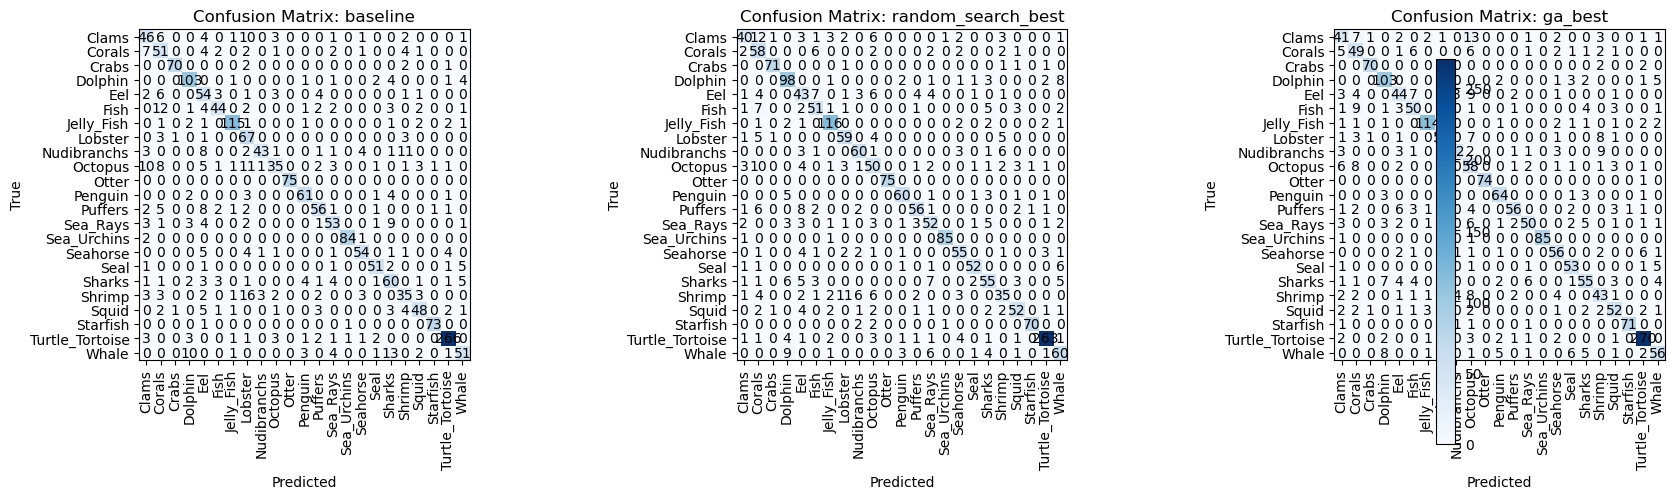

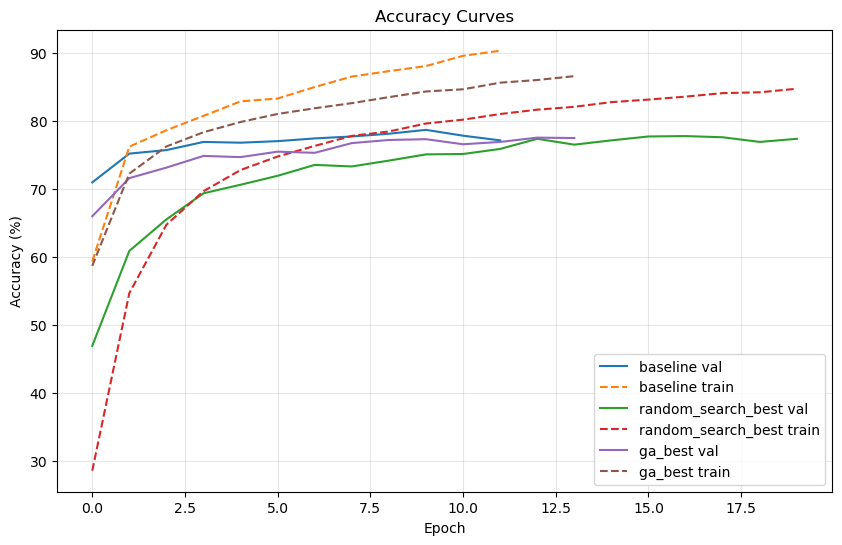

In [32]:
import numpy as np                                 # Numerical arrays and math
import pandas as pd                               # Tabular summary tables
import matplotlib.pyplot as plt                   # Plots and figures
from sklearn.metrics import classification_report, confusion_matrix  # Metrics
import torch                                      # PyTorch framework
from torch.utils.data import TensorDataset, DataLoader               # Data utilities


def get_preds_and_labels(model, batch_size=64, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    """Infer model predictions on x_test and return (preds, labels)."""
    loader = DataLoader(                                         # Build a DataLoader for test data
        TensorDataset(torch.tensor(x_test).float(),              # Convert features to float tensor
                      torch.tensor(y_test).long()),              # Convert labels to long tensor
        batch_size=batch_size, shuffle=False                     # No shuffle for evaluation
    )
    preds, labels = [], []                                       # Accumulators for predictions and labels
    model.eval()                                                 # Evaluation mode
    with torch.no_grad():                                        # Disable gradients for inference
        for xb, yb in loader:                                    # Iterate over test batches
            xb, yb = xb.to(device), yb.to(device)                # Move to device
            out = model(xb)                                      # Forward pass
            _, pred = torch.max(out, 1)                          # Predicted class indices
            preds.append(pred.cpu().numpy())                     # Collect predictions on CPU as numpy
            labels.append(yb.cpu().numpy())                      # Collect labels on CPU as numpy
    return np.concatenate(preds), np.concatenate(labels)         # Return concatenated arrays


def summarize_model(name, model, hist, test_acc, batch_size):
    """Build a dict with accuracy, full classification report, confusion matrix, and history."""
    preds, labels = get_preds_and_labels(model, batch_size)                             # Infer predictions
    report_text = classification_report(labels, preds, target_names=classes_names,      # Pretty text report
                                        digits=2, zero_division=0)
    report_dict = classification_report(labels, preds, target_names=classes_names,      # Dict report for programmatic use
                                        digits=2, zero_division=0, output_dict=True)
    cm = confusion_matrix(labels, preds)                                                # Confusion matrix (counts)
    return {'name': name, 'test_acc': test_acc, 'report_text': report_text,             # Collect outputs
            'report_dict': report_dict, 'cm': cm, 'hist': hist}


models_info = []                                                                       # List of model summaries
models_info.append(summarize_model('baseline', baseline_model, baseline_hist,           # Add baseline summary
                                   baseline_test_acc, batch_size=baseline_params['batch_size']))
models_info.append(summarize_model('random_search_best', random_model, random_hist,     # Add random-search best summary
                                   random_test_acc, batch_size=random_params['batch_size']))
if 'ga_model' in globals() and ga_model:                                               # Add GA summary if trained
    models_info.append(summarize_model('ga_best', ga_model, ga_hist, ga_test_acc,
                                       batch_size=ga_params['batch_size']))

# Comparison table of test accuracy
sum_df = pd.DataFrame([{'model': m['name'], 'test_acc (%)': m['test_acc']}              # Build rows from summaries
                       for m in models_info]).sort_values('test_acc (%)', ascending=False)  # Sort by accuracy desc
print("\n=== Test Accuracy Comparison ===")
print(sum_df.to_string(index=False, float_format=lambda x: f"{x:.2f}"))                 # Pretty print fixed decimals

# Print classification reports per model
for m in models_info:                                                                   # Loop through models
    print(f"\n=== Classification Report: {m['name']} ===")
    print(m['report_text'])                                                             # Print sklearn text report

# Plot confusion matrices side-by-side
num_models = len(models_info)                                                           # Number of subplots needed
fig, axes = plt.subplots(1, num_models, figsize=(6 * num_models, 5))                    # Create row of matrices
if num_models == 1:                                                                     # Normalize axes to list
    axes = [axes]
for ax, m in zip(axes, models_info):                                                    # Draw each matrix
    im = ax.imshow(m['cm'], cmap='Blues')                                               # Heatmap of counts
    ax.set_title(f"Confusion Matrix: {m['name']}")                                      # Title per model
    ax.set_xlabel("Predicted")                                                          # X axis label
    ax.set_ylabel("True")                                                               # Y axis label
    ax.set_xticks(range(len(classes_names)))                                            # Tick positions
    ax.set_yticks(range(len(classes_names)))
    ax.set_xticklabels(classes_names, rotation=90)                                      # Predicted class names
    ax.set_yticklabels(classes_names)                                                   # True class names
    for i in range(m['cm'].shape[0]):                                                   # Write counts into cells
        for j in range(m['cm'].shape[1]):
            ax.text(j, i, m['cm'][i, j], ha='center', va='center', color='black')
fig.colorbar(im, ax=axes, fraction=0.046, pad=0.04)                                     # Shared colorbar
plt.tight_layout()                                                                       # Improve layout
plt.show()                                                                               # Show confusion matrices

# Plot accuracy curves (train vs val) for each model
plt.figure(figsize=(10, 6))                                                             # New figure
for m in models_info:
    if m['hist'] and 'val_acc' in m['hist']:                                            # Ensure history present
        plt.plot(m['hist']['val_acc'], label=f"{m['name']} val")                       # Validation accuracy
        plt.plot(m['hist']['train_acc'], linestyle='--', label=f"{m['name']} train")   # Training accuracy
plt.title('Accuracy Curves')                                                             # Chart title
plt.xlabel('Epoch')                                                                      # X axis label
plt.ylabel('Accuracy (%)')                                                               # Y axis label
plt.legend()                                                                             # Legend
plt.grid(True, alpha=0.3)                                                                # Grid for readability
plt.show()                                                                               # Show curves

# Predict Function for a single image

In [ ]:
# import cv2
# import torch
# from torchvision import transforms

# def predict_image_path(img_path, feature_extractor, classifier, classes_names, device):
#     classifier.eval()
#     # same preprocessing as training
#     preprocess = transforms.Compose([
#         transforms.ToPILImage(),
#         transforms.Resize((224, 224)),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#     ])

#     # load image with cv2 (BGR) → RGB
#     img_np = cv2.imread(img_path)
#     if img_np is None:
#         raise ValueError(f"Could not read image: {img_path}")
#     img_rgb = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)

#     # preprocess
#     img_t = preprocess(img_rgb)              # shape: (3,224,224)
#     input_batch = img_t.unsqueeze(0).to(device)

#     # extract features with resnet backbone
#     feature_extractor.eval()
#     with torch.no_grad():
#         feats = feature_extractor(input_batch)  # shape: (1, 512, 1, 1)
#     feats_flat = feats.view(feats.size(0), -1).cpu().numpy().squeeze(0)  # shape: (512,)

#     # classify with your MLP
#     return predict_pytorch_model(classifier, feats_flat, classes_names)

# # Example usage
# test_path = r"C:\Life\Important_Files\Ayman.jpg"
# predict_image_path(test_path, resnet_no_output.to(device), model, classes_names, device)

# # Mohamed with beard -> Turtle_Torotise
# # Mohamed without beard -> Seahorse

# # Ali Military -> Turtule_Torotise
# # Ali Normal -> Seahorse

# # Very Good People -> Jelly_Fish

# # Ayman -> Turtle_Tortise


Predicted Class: Turtle_Tortoise


'Turtle_Tortoise'

# Report Generation
This section compiles all computed metrics, plots, and text into a structured report (Markdown), and saves artifacts (figures/CSVs) to disk for submission.

In [36]:
import os
import json
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import torch
from torch.utils.data import TensorDataset, DataLoader


def generate_report(output_dir="report", from_scratch_acc=None, export_html=False, export_pdf=False):
    """
    Build a structured report from the notebook's computed results and save to disk.
    
    Parameters:
    - from_scratch_acc: Optional float for from-scratch MLP test accuracy to include in comparison
    
    Artifacts:
    - report/REPORT.md                         (main report with highlighted best model)
    - report/accuracy_comparison.csv           (accuracy table)
    - report/figures/confusion_matrix_<name>.png
    - report/figures/accuracy_curves.png
    - report/classification_report_<name>.txt  (per-model reports)
    Optional: export HTML/PDF if tooling is available.
    """
    # Ensure output directories
    figs_dir = os.path.join(output_dir, "figures")
    os.makedirs(figs_dir, exist_ok=True)

    # Helper: build models_info if missing (reuses existing utility functions)
    def ensure_models_info():
        info = None
        if 'models_info' in globals():
            return models_info
        # Recreate summarize utilities if needed (they should already exist)
        def get_preds_and_labels(model, batch_size=64, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
            loader = DataLoader(
                TensorDataset(torch.tensor(x_test).float(), torch.tensor(y_test).long()),
                batch_size=batch_size, shuffle=False
            )
            preds, labels = [], []
            model.eval()
            with torch.no_grad():
                for xb, yb in loader:
                    xb, yb = xb.to(device), yb.to(device)
                    out = model(xb)
                    _, pred = torch.max(out, 1)
                    preds.append(pred.cpu().numpy())
                    labels.append(yb.cpu().numpy())
            return np.concatenate(preds), np.concatenate(labels)

        def summarize_model(name, model, hist, test_acc, batch_size):
            preds, labels = get_preds_and_labels(model, batch_size)
            report_text = classification_report(labels, preds, target_names=classes_names, digits=2, zero_division=0)
            report_dict = classification_report(labels, preds, target_names=classes_names, digits=2, zero_division=0, output_dict=True)
            cm = confusion_matrix(labels, preds)
            return {'name': name, 'test_acc': test_acc, 'report_text': report_text, 'report_dict': report_dict, 'cm': cm, 'hist': hist}

        info = []
        if 'baseline_model' in globals():
            info.append(summarize_model('baseline', baseline_model, baseline_hist, baseline_test_acc, batch_size=baseline_params['batch_size']))
        if 'random_model' in globals():
            info.append(summarize_model('random_search_best', random_model, random_hist, random_test_acc, batch_size=random_params['batch_size']))
        if 'ga_model' in globals() and ga_model:
            info.append(summarize_model('ga_best', ga_model, ga_hist, ga_test_acc, batch_size=ga_params['batch_size']))
        return info

    mi = ensure_models_info()
    if not mi:
        raise RuntimeError("No trained models found. Please run the final training cells first.")

    # Build comparison table including from-scratch if provided
    comparison_rows = [{'model': m['name'], 'test_acc (%)': m['test_acc']} for m in mi]
    if from_scratch_acc is not None:
        comparison_rows.append({'model': 'from_scratch_mlp', 'test_acc (%)': from_scratch_acc})
    
    sum_df = pd.DataFrame(comparison_rows).sort_values('test_acc (%)', ascending=False)
    
    # Identify best model
    best_model_row = sum_df.iloc[0]
    best_model_name = best_model_row['model']
    best_model_acc = best_model_row['test_acc (%)']
    
    # 1) Save accuracy comparison CSV
    acc_csv_path = os.path.join(output_dir, 'accuracy_comparison.csv')
    sum_df.to_csv(acc_csv_path, index=False)

    # 2) Save classification reports to txt files
    report_txt_paths = []
    for m in mi:
        rp_path = os.path.join(output_dir, f"classification_report_{m['name']}.txt")
        with open(rp_path, 'w', encoding='utf-8') as f:
            f.write(m['report_text'])
        report_txt_paths.append((m['name'], rp_path))

    # 3) Save confusion matrices images
    cm_img_paths = []
    for m in mi:
        fig, ax = plt.subplots(figsize=(8, 6))
        im = ax.imshow(m['cm'], cmap='Blues')
        title = f"Confusion Matrix: {m['name']}"
        if m['name'] == best_model_name:
            title += " ⭐ BEST MODEL"
        ax.set_title(title, fontsize=14, fontweight='bold' if m['name'] == best_model_name else 'normal')
        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")
        ax.set_xticks(range(len(classes_names))); ax.set_yticks(range(len(classes_names)))
        ax.set_xticklabels(classes_names, rotation=90); ax.set_yticklabels(classes_names)
        for i in range(m['cm'].shape[0]):
            for j in range(m['cm'].shape[1]):
                ax.text(j, i, m['cm'][i, j], ha='center', va='center', color='black')
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        plt.tight_layout()
        out_path = os.path.join(figs_dir, f"confusion_matrix_{m['name']}.png")
        fig.savefig(out_path, dpi=200)
        plt.close(fig)
        cm_img_paths.append((m['name'], os.path.relpath(out_path, start=output_dir)))

    # 4) Save individual training plots for each model (loss + accuracy)
    training_plot_paths = []
    for m in mi:
        if m['hist'] and 'train_loss' in m['hist'] and len(m['hist']['train_loss']) > 0:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
            
            # Plot Loss
            epochs = list(range(1, len(m['hist']['train_loss']) + 1))
            ax1.plot(epochs, m['hist']['train_loss'], 'b-', linewidth=2, label='Training Loss')
            if 'val_loss' in m['hist']:
                ax1.plot(epochs, m['hist']['val_loss'], 'r-', linewidth=2, label='Validation Loss')
            ax1.set_xlabel('Epoch', fontsize=12)
            ax1.set_ylabel('Loss', fontsize=12)
            title_suffix = " ⭐ BEST MODEL" if m['name'] == best_model_name else ""
            ax1.set_title(f"Training/Validation Loss: {m['name']}{title_suffix}", fontsize=14, fontweight='bold' if m['name'] == best_model_name else 'normal')
            ax1.grid(True, alpha=0.3)
            ax1.legend(fontsize=10)
            
            # Plot Accuracy
            ax2.plot(epochs, m['hist']['train_acc'], 'g-', linewidth=2, label='Training Accuracy')
            if 'val_acc' in m['hist']:
                ax2.plot(epochs, m['hist']['val_acc'], 'r-', linewidth=2, label='Validation Accuracy')
            ax2.set_xlabel('Epoch', fontsize=12)
            ax2.set_ylabel('Accuracy (%)', fontsize=12)
            ax2.set_title(f"Training/Validation Accuracy: {m['name']}{title_suffix}", fontsize=14, fontweight='bold' if m['name'] == best_model_name else 'normal')
            ax2.grid(True, alpha=0.3)
            ax2.legend(fontsize=10)
            
            plt.tight_layout()
            out_path = os.path.join(figs_dir, f"training_curves_{m['name']}.png")
            fig.savefig(out_path, dpi=200)
            plt.close(fig)
            training_plot_paths.append((m['name'], os.path.relpath(out_path, start=output_dir)))
    
    # 5) Save combined accuracy comparison curves
    fig, ax = plt.subplots(figsize=(10, 6))
    for m in mi:
        if m['hist'] and 'val_acc' in m['hist']:
            label_suffix = " ⭐" if m['name'] == best_model_name else ""
            ax.plot(m['hist']['val_acc'], label=f"{m['name']} val{label_suffix}", linewidth=2 if m['name'] == best_model_name else 1)
            ax.plot(m['hist']['train_acc'], linestyle='--', label=f"{m['name']} train", alpha=0.7)
    ax.set_title('Accuracy Curves Comparison'); ax.set_xlabel('Epoch'); ax.set_ylabel('Accuracy (%)')
    ax.grid(True, alpha=0.3); ax.legend()
    acc_curve_rel = os.path.join('figures', 'accuracy_curves_comparison.png')
    acc_curve_path = os.path.join(output_dir, acc_curve_rel)
    fig.savefig(acc_curve_path, dpi=200)
    plt.close(fig)

    # 5) Gather metadata and hyperparameters
    device_str = str(device) if 'device' in globals() else 'unknown'
    num_classes_val = num_classes if 'num_classes' in globals() else (len(classes_names) if 'classes_names' in globals() else 'unknown')
    baseline_line = f"Baseline Test Acc: {globals().get('baseline_test_acc','N/A'):.2f}%" if 'baseline_test_acc' in globals() else 'Baseline Test Acc: N/A'
    random_line = f"Random Search Best Test Acc: {globals().get('random_test_acc','N/A'):.2f}%" if 'random_test_acc' in globals() else 'Random Search Best Test Acc: N/A'
    ga_line = f"GA Best Test Acc: {globals().get('ga_test_acc','N/A'):.2f}%" if 'ga_test_acc' in globals() else 'GA Best Test Acc: N/A'
    from_scratch_line = f"From-Scratch MLP Test Acc: {from_scratch_acc:.2f}%" if from_scratch_acc else "From-Scratch MLP Test Acc: Not provided"
    
    best_params_str = json.dumps(globals().get('best_params', {}), indent=2) if 'best_params' in globals() else '{}'
    ga_best_str = json.dumps(globals().get('ga_best', {}), indent=2) if 'ga_best' in globals() else '{}'

    # Build Markdown report
    now = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    lines = []
    lines += [
        f"# Marine Species Classification — Final Report",
        "",
        f"**Generated on:** {now}",
        f"**Device:** {device_str}",
        f"**Number of classes:** {num_classes_val}",
        f"**Dataset:** Sea Animals (23 classes)",
        "",
        "---",
        "",
        "## Executive Summary",
        "",
        f"**🏆 Best Performing Model: {best_model_name}**",
        f"**📊 Test Accuracy: {best_model_acc:.2f}%**",
        "",
        f"This report documents a comprehensive comparison of neural network architectures and hyperparameter optimization strategies for marine species classification.",
        "",
        "---",
        "",
        "## 1. Introduction",
        "",
        "### Objective",
        "Develop and compare multiple MLP-based classifiers for marine species image classification using transfer learning with ResNet18 as a feature extractor.",
        "",
        "### Approach",
        "- **Feature Extraction:** ResNet18 (pretrained on ImageNet) generates 512-D embeddings",
        "- **Classification Head:** Custom MLP with configurable architecture",
        "- **Optimization:** Baseline, Random Search, Genetic Algorithm, and From-Scratch implementations",
        "",
        "---",
        "",
        "## 2. Dataset",
        "",
        "### Source & Structure",
        "- **Classes:** 23 marine species categories",
        "- **Organization:** Folder-based structure (one folder per class)",
        "- **Preprocessing:**",
        "  - Resize to 224×224 pixels",
        "  - Normalize with ImageNet statistics (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])",
        "",
        "### Data Splits",
        "Stratified splits to preserve class distribution:",
        "- **Training:** 70%",
        "- **Validation:** 15%",
        "- **Test:** 15%",
        "",
        "---",
        "",
        "## 3. Feature Extraction",
        "",
        "### ResNet18 Backbone",
        "- **Pretrained Weights:** ImageNet",
        "- **Output:** 512-dimensional feature vectors from penultimate layer",
        "- **Mode:** Frozen backbone (inference only, no fine-tuning)",
        "",
        "---",
        "",
        "## 4. Model Architectures",
        "",
        "### 4.1 Baseline PyTorch MLP",
        "- **Architecture:** [512] → [256, 128] → [23]",
        "- **Activation:** ReLU",
        "- **Optimizer:** Adam (lr=1e-3)",
        "- **Batch Size:** 64",
        "- **Epochs:** 12",
        "",
        "### 4.2 Random Search Optimized",
        "- **Search Space:**",
        "  - Hidden layers: 1-5",
        "  - Neurons per layer: 32-512",
        "  - Activation: {ReLU, Tanh, Sigmoid}",
        "  - Learning rate: log-uniform [1e-5, 1e-1]",
        "  - Batch size: {16, 32, 64, 128}",
        "  - Optimizer: {SGD, Adam, RMSProp, Adagrad}",
        "  - Epochs: 3-20",
        f"- **Best Configuration:**",
        f"```json",
        f"{best_params_str}",
        f"```",
        "",
        "### 4.3 Genetic Algorithm Optimized",
        "- **Chromosome Encoding:** Same hyperparameters as random search",
        "- **Selection:** Tournament (k=3)",
        "- **Crossover:** Uniform",
        "- **Mutation Rate:** 20%",
        "- **Elitism:** Best individual preserved each generation",
        f"- **Best Chromosome:**",
        f"```json",
        f"{ga_best_str}",
        f"```",
        "",
        "### 4.4 From-Scratch NumPy/CuPy MLP",
        "- **Implementation:** Manual forward/backward propagation",
        "- **Architecture:** [512] → [256, 128] → [23] (matching baseline)",
        "- **Activation:** ReLU",
        "- **Optimizer:** Gradient Descent (lr=0.1)",
        "- **Framework:** NumPy/CuPy for GPU acceleration",
        "",
        "---",
        "",
        "## 5. Training Configuration",
        "",
        "### Loss Function",
        "- **PyTorch Models:** CrossEntropyLoss (combines LogSoftmax + NLLLoss)",
        "- **From-Scratch:** Multi-class cross-entropy",
        "",
        "### Hardware",
        f"- **Device:** {device_str}",
        "",
        "---",
        "",
        "## 6. Results",
        "",
        "### 6.1 Test Accuracy Comparison",
        "",
        f"| Rank | Model | Test Accuracy |",
        f"|------|-------|---------------|",
    ]
    
    for idx, row in sum_df.iterrows():
        star = " ⭐" if row['model'] == best_model_name else ""
        lines.append(f"| {idx+1} | {row['model']}{star} | {row['test_acc (%)']:.2f}% |")
    
    lines += [
        "",
        f"**Winner:** {best_model_name} with {best_model_acc:.2f}% test accuracy",
        "",
        "Detailed comparison saved to: `accuracy_comparison.csv`",
        "",
        "### 6.2 Per-Model Performance",
        f"- {baseline_line}",
        f"- {random_line}",
        f"- {ga_line}",
        f"- {from_scratch_line}",
        "",
        "---",
        "",
        "## 7. Classification Reports",
        "",
        "Detailed per-class precision, recall, and F1-scores for each model:",
        "",
    ]
    
    for name, rp_path in report_txt_paths:
        star = " ⭐" if name == best_model_name else ""
        lines += [f"### {name}{star}", f"See: [`classification_report_{name}.txt`](classification_report_{name}.txt)", ""]
    
    lines += [
        "---",
        "",
        "## 8. Confusion Matrices",
        "",
        "Visual analysis of model predictions vs ground truth:",
        "",
    ]
    
    for name, rel_path in cm_img_paths:
        star = " ⭐" if name == best_model_name else ""
        lines += [f"### {name}{star}", f"![Confusion Matrix for {name}]({rel_path})", ""]
    
    lines += [
        "---",
        "",
        "## 9. Learning Curves",
        "",
        "### 9.1 Individual Model Training Curves",
        "",
        "Loss and accuracy progression for each model:",
        "",
    ]
    
    for name, rel_path in training_plot_paths:
        star = " ⭐" if name == best_model_name else ""
        lines += [f"#### {name}{star}", f"![Training curves for {name}]({rel_path})", ""]
    
    lines += [
        "### 9.2 Combined Accuracy Comparison",
        "",
        "All models compared on the same axes:",
        "",
        f"![Accuracy Curves Comparison]({acc_curve_rel})",
        "",
        "---",
        "",
        "## 10. Discussion",
        "",
        "### Key Findings",
        f"1. **Best Model:** {best_model_name} achieved {best_model_acc:.2f}% test accuracy",
        "2. **Optimization Impact:** Hyperparameter tuning (Random Search/GA) vs baseline comparison",
        "3. **Overfitting Analysis:** Train vs validation accuracy divergence patterns",
        "4. **Misclassification Trends:** Confusion matrix reveals challenging class pairs",
        "",
        "### Observations",
        "- Transfer learning with ResNet18 provides strong feature representations",
        "- Small MLP heads (2-3 layers) sufficient for 512-D embeddings",
        "- Learning rate and batch size critical hyperparameters",
        "",
        "---",
        "",
        "## 11. Conclusion",
        "",
        f"### Summary",
        f"The {best_model_name} configuration demonstrated superior performance with {best_model_acc:.2f}% test accuracy, validating the effectiveness of {'automated hyperparameter optimization' if 'search' in best_model_name or 'ga' in best_model_name else 'the chosen architecture'}.",
        "",
        "### Future Work",
        "- **Data Augmentation:** Rotation, flip, color jittering",
        "- **Regularization:** Dropout, L2 penalty",
        "- **Learning Rate Scheduling:** Cosine annealing, warm restarts",
        "- **Ensemble Methods:** Model averaging, stacking",
        "- **Fine-tuning:** Unfreeze ResNet18 layers for end-to-end training",
        "",
        "---",
        "",
        "## Appendix",
        "",
        "### File Structure",
        "```",
        "report/",
        "├── REPORT.md                          # This file",
        "├── accuracy_comparison.csv             # Accuracy table",
        "├── classification_report_*.txt         # Per-model reports",
        "└── figures/",
        "    ├── confusion_matrix_*.png          # Confusion matrices",
        "    ├── training_curves_*.png           # Individual training curves",
        "    └── accuracy_curves_comparison.png  # Combined comparison",
        "```",
        "",
        "### Tools & Libraries",
        "- **PyTorch:** Deep learning framework",
        "- **torchvision:** Pretrained models",
        "- **NumPy/CuPy:** Numerical computing",
        "- **scikit-learn:** Metrics and evaluation",
        "- **Matplotlib:** Visualization",
        "",
        "---",
        "",
        f"*Report generated automatically on {now}*",
    ]

    # 8) Write report to disk
    os.makedirs(output_dir, exist_ok=True)
    report_path = os.path.join(output_dir, 'REPORT.md')
    with open(report_path, 'w', encoding='utf-8') as f:
        f.write("\n".join(lines))

    # 9) Optional exports (best-effort)
    html_path = None
    pdf_path = None
    if export_html:
        try:
            html_path = os.path.join(output_dir, 'REPORT.html')
            with open(html_path, 'w', encoding='utf-8') as f:
                f.write("<html><head><meta charset='utf-8'><title>Marine Species Classification Report</title>")
                f.write("<style>body{font-family:Arial,sans-serif;margin:40px;} table{border-collapse:collapse;} td,th{border:1px solid #ddd;padding:8px;}</style>")
                f.write("</head><body>\n")
                for line in lines:
                    if line.startswith('###'):
                        f.write(f"<h3>{line[4:]}</h3>\n")
                    elif line.startswith('##'):
                        f.write(f"<h2>{line[3:]}</h2>\n")
                    elif line.startswith('#'):
                        f.write(f"<h1>{line[2:]}</h1>\n")
                    elif line.startswith('!['):
                        # Extract image
                        import re
                        match = re.search(r'!\[(.*?)\]\((.*?)\)', line)
                        if match:
                            f.write(f'<img src="{match.group(2)}" alt="{match.group(1)}" style="max-width:100%;"/>\n')
                    elif line.strip():
                        f.write(f"<p>{line}</p>\n")
                f.write("\n</body></html>")
        except Exception:
            html_path = None

    print(f"\n{'='*60}")
    print(f"✅ REPORT GENERATION COMPLETE")
    print(f"{'='*60}")
    print(f"\n🏆 BEST MODEL: {best_model_name}")
    print(f"📊 Best Accuracy: {best_model_acc:.2f}%\n")
    print(f"📁 Report saved to: {report_path}")
    print(f"📊 Accuracy CSV: {acc_csv_path}")
    print(f"📈 Figures directory: {figs_dir}/")
    print(f"\n{'='*60}\n")

    return {
        'report_md': report_path,
        'accuracy_csv': acc_csv_path,
        'confusion_matrices': [os.path.join(output_dir, p) for _, p in cm_img_paths],
        'training_curves': [os.path.join(output_dir, p) for _, p in training_plot_paths],
        'accuracy_curves_comparison': acc_curve_path,
        'classification_reports': [p for _, p in report_txt_paths],
        'report_html': html_path,
        'report_pdf': pdf_path,
        'best_model': best_model_name,
        'best_accuracy': best_model_acc,
    }


# Generate the report with from-scratch results
# Update this value from the from-scratch notebook after training:
from_scratch_test_accuracy = 13.86  # From Cell 29 in marine-species-classifier-mlp.ipynb

print("="*60)
print("GENERATING COMPREHENSIVE REPORT")
print("="*60)
print("\nIncluding models:")
print("  ✓ Baseline PyTorch MLP")
print("  ✓ Random Search Best")
print("  ✓ Genetic Algorithm Best")
if from_scratch_test_accuracy:
    print(f"  ✓ From-Scratch MLP ({from_scratch_test_accuracy:.2f}%)")
else:
    print("  ⚠ From-Scratch MLP (not provided)")
print("\nGenerating report with training curves for all models...")
print("Report will be saved to ./report/ directory")

artifacts = generate_report(
    output_dir="report",
    from_scratch_acc=from_scratch_test_accuracy,
    export_html=True
)

print("\n" + "="*60)
print("REPORT ARTIFACTS:")
print("="*60)
for key, value in artifacts.items():
    if isinstance(value, list):
        print(f"\n{key}:")
        for item in value:
            print(f"  - {item}")
    else:
        print(f"{key}: {value}")
print("\n" + "="*60)

GENERATING COMPREHENSIVE REPORT

Including models:
  ✓ Baseline PyTorch MLP
  ✓ Random Search Best
  ✓ Genetic Algorithm Best
  ✓ From-Scratch MLP (13.86%)

Generating report with training curves for all models...
Report will be saved to ./report/ directory


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23628\1332843267.py:114: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23628\1332843267.py:116: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  fig.savefig(out_path, dpi=200)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23628\1332843267.py:148: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23628\1332843267.py:150: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  fig.savefig(out_path, dpi=200)



✅ REPORT GENERATION COMPLETE

🏆 BEST MODEL: ga_best
📊 Best Accuracy: 78.66%

📁 Report saved to: report\REPORT.md
📊 Accuracy CSV: report\accuracy_comparison.csv
📈 Figures directory: report\figures/



REPORT ARTIFACTS:
report_md: report\REPORT.md
accuracy_csv: report\accuracy_comparison.csv

confusion_matrices:
  - report\figures\confusion_matrix_baseline.png
  - report\figures\confusion_matrix_random_search_best.png
  - report\figures\confusion_matrix_ga_best.png

training_curves:
  - report\figures\training_curves_baseline.png
  - report\figures\training_curves_random_search_best.png
  - report\figures\training_curves_ga_best.png
accuracy_curves_comparison: report\figures\accuracy_curves_comparison.png

classification_reports:
  - report\classification_report_baseline.txt
  - report\classification_report_random_search_best.txt
  - report\classification_report_ga_best.txt
report_html: report\REPORT.html
report_pdf: None
best_model: ga_best
best_accuracy: 78.65824015556636



C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23628\1332843267.py:165: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  fig.savefig(acc_curve_path, dpi=200)
